In [ ]:
"""PointNet
Reference:
https://github.com/yanx27/Pointnet_Pointnet2_pytorch/blob/master/models/pointnet_utils.py

"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class STN3d(nn.Module):
    def __init__(self, channel=3):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(channel, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.iden = torch.from_numpy(np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)).reshape(1, 9)

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = self.iden.repeat(batchsize, 1).to(x.device)
        x = x + iden
        x = x.view(-1, 3, 3)
        return x


class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k
        self.iden = torch.from_numpy(np.eye(self.k).flatten().astype(np.float32)).reshape(1, self.k * self.k)

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = self.iden.repeat(batchsize, 1).to(x.device)

        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x


class PointNetEncoder(nn.Module):
    """Encoder for PointNet

    Args:
        nn (_type_): _description_
    """

    def __init__(self,
                 in_channels: int,
                 input_transform: bool=True,
                 feature_transform: bool=True,
                 is_seg: bool=False,  
                 **kwargs
                 ):
        """_summary_

        Args:
            in_channels (int): feature size of input 
            input_transform (bool, optional): whether to use transformation for coordinates. Defaults to True.
            feature_transform (bool, optional): whether to use transformation for features. Defaults to True.
            is_seg (bool, optional): for segmentation or classification. Defaults to False.
        """
        super().__init__()
        self.stn = STN3d(in_channels) if input_transform else None
        self.conv0_1 = torch.nn.Conv1d(in_channels, 64, 1)
        self.conv0_2 = torch.nn.Conv1d(64, 64, 1)

        self.conv1 = torch.nn.Conv1d(64, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn0_1 = nn.BatchNorm1d(64)
        self.bn0_2 = nn.BatchNorm1d(64)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fstn = STNkd(k=64) if feature_transform else None
        self.out_channels = 1024 + 64 if is_seg else 1024 
         
    def forward_cls_feat(self, pos, x=None):
        if hasattr(pos, 'keys'):
            x = pos['x']
        if x is None:
            x = pos.transpose(1, 2).contiguous()
        
        B, D, N = x.size()
        if self.stn is not None:
            trans = self.stn(x)
            x = x.transpose(2, 1)
            if D > 3:
                feature = x[:, :, 3:]
                x = x[:, :, :3]
            x = torch.bmm(x, trans)
            if D > 3:
                x = torch.cat([x, feature], dim=2)
            x = x.transpose(2, 1)
        x = F.relu(self.bn0_1(self.conv0_1(x)))
        x = F.relu(self.bn0_2(self.conv0_2(x)))

        if self.fstn is not None:
            trans_feat = self.fstn(x)
            x = x.transpose(2, 1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2, 1)
        else:
            trans_feat = None
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        return x

    def forward_seg_feat(self, pos, x=None):
        if hasattr(pos, 'keys'):
            x = pos.get('x', None)
        if x is None:
            x = pos.transpose(1, 2).contiguous()

        B, D, N = x.size()
        if self.stn is not None:
            trans = self.stn(x)
            x = x.transpose(2, 1)
            if D > 3:
                feature = x[:, :, 3:]
                x = x[:, :, :3]
            x = torch.bmm(x, trans)
            if D > 3:
                x = torch.cat([x, feature], dim=2)
            x = x.transpose(2, 1)
        x = F.relu(self.bn0_1(self.conv0_1(x)))
        x = F.relu(self.bn0_2(self.conv0_2(x)))

        if self.fstn is not None:
            trans_feat = self.fstn(x)
            x = x.transpose(2, 1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2, 1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024, 1).repeat(1, 1, N)
        return pos, torch.cat([pointfeat, x], 1)
    
    def forward(self, x, features=None):
        return self.forward_cls_features(x)

In [ ]:
json_files = ["../data/fsg_accel_2024_08_16-11_06_03_recovered_filtered_0_labels.json", "../data/skidpad_2025-08-06-17_26_12_merged_filtered_0_labels.json"]
pre_trained_path = "./pre-trained/pointent_pre_trainder.pth"

In [26]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.backends.cudnn.version())


True
12.4
90100


In [ ]:
import torch
import os


# Load checkpoint
checkpoint = torch.load("./pre-trained/pointnet_pre_trainder.pth", map_location="cuda")
state_dict = checkpoint['model']

# Strip "encoder." prefix and ignore classifier weights
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith("encoder."):
        new_key = k[len("encoder."):]  # remove prefix
        new_state_dict[new_key] = v

# Initialize encoder
encoder = PointNetEncoder(in_channels=4)

# Load filtered state_dict
encoder.load_state_dict(new_state_dict)
encoder.eval()
encoder.to("cuda")


In [ ]:
import torch
import torch.nn as nn

# Make sure your encoder is loaded
encoder = PointNetEncoder(in_channels=4)
encoder.eval()
encoder.to("cuda")

# Simple classifier head
num_classes = 15
classifier = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, num_classes)
)

# Wrapper to combine encoder + classifier
# Wrapper to combine encoder + classifier
class PointNetWithHead(nn.Module):
    def __init__(self, encoder, classifier):
        super().__init__()
        self.encoder = encoder
        self.classifier = classifier
        
    def forward(self, x):
        # Pass x as B,C,N and avoid automatic transpose
        features = self.encoder.forward_cls_feat(x, x=x)
        out = self.classifier(features)
        return out


model = PointNetWithHead(encoder, classifier)
model.eval()
model.to("cuda")

# Generate some artificial point cloud data
B, C, N = 8, 4, 1024
fake_data = torch.randn(B, C, N).cuda()

# Forward pass
with torch.no_grad():
    outputs = model(fake_data)

print("Output shape:", outputs.shape)  # should be (B, num_classes)
print("Output:", outputs)


In [ ]:
import json
import torch
from torch.utils.data import Dataset
import numpy as np

class ConeClusterDataset(Dataset):
    def __init__(self, json_files, num_points=128):
        """
        json_files: list of paths to your JSON cluster files
        num_points: fixed number of points per cluster
        """
        self.samples = []
        self.num_points = num_points

        for file_path in json_files:
            with open(file_path, 'r') as f:
                data = json.load(f)
            for frame in data.values():
                for cluster in frame['clusters']:
                    points = cluster['points']
                    label = cluster['label']
                    if label == 255:
                        label=0
                    self.samples.append((points, label))

        

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        points, label = self.samples[idx]

        # Convert to numpy array (N, 4) [x, y, z, intensity]
        pts = np.array([[p['x'], p['y'], p['z'], p['i']] for p in points], dtype=np.float32)
        
        # Normalize coordinates relative to centroid
        centroid = pts[:, :3].mean(axis=0, keepdims=True)  # (1,3)
        pts[:, :3] -= centroid

        # Normalize intensity
        pts[:, 3] /= 255.0

        # Downsample or pad
        N = pts.shape[0]
        if N >= self.num_points:
            choice = np.random.choice(N, self.num_points, replace=False)
            pts = pts[choice]
        else:
            pad = np.zeros((self.num_points - N, pts.shape[1]), dtype=np.float32)
            pts = np.vstack([pts, pad])

        # Transpose to (features, points) for PointNet
        return torch.tensor(pts, dtype=torch.float32), torch.tensor(label, dtype=torch.long)



In [ ]:
from torch.utils.data import DataLoader

dataset = ConeClusterDataset(["../data/fsg_accel_2024_08_16-11_06_03_recovered_filtered_0_labels.json", "../data/skidpad_2025-08-06-17_26_12_merged_filtered_0_labels.json"], num_points=128)
loader = DataLoader(dataset, batch_size=16, shuffle=True)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

# Assume PointNetEncoder and ConeClusterDataset are defined as before

# ----------------------------
# 1. Load Pretrained Encoder
# ----------------------------
encoder = PointNetEncoder(in_channels=4)  # 4 channels: x, y, z, intensity
checkpoint = torch.load("../models/pre-trained/pointnet_pre_trainder.pth", map_location="cpu")
state_dict = checkpoint['model']

# Remove the 'encoder.' prefix from keys if present
new_state_dict = {k.replace("encoder.", ""): v for k, v in state_dict.items() if "prediction" not in k}
encoder.load_state_dict(new_state_dict, strict=False)
encoder.eval()

# ----------------------------
# 2. Add a classifier head
# ----------------------------
num_classes = 4  # adjust to your labels
classifier = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, num_classes)
)

class PointNetWithHead(nn.Module):
    def __init__(self, encoder, classifier):
        super().__init__()
        self.encoder = encoder
        self.classifier = classifier
    
    def forward(self, x):
        features = self.encoder.forward_cls_feat(x)  # get global features
        out = self.classifier(features)
        return out

model = PointNetWithHead(encoder, classifier)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ----------------------------
# 3. Prepare Dataset & Dataloader
# ----------------------------
train_files = ["../data/fsg_accel_2024_08_16-11_06_03_recovered_filtered_0_labels.json", "../data/skidpad_2025-08-06-17_26_12_merged_filtered_0_labels.json"]  # replace with your paths
train_dataset = ConeClusterDataset(train_files, num_points=128)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)

# ----------------------------
# 4. Training Setup
# ----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ----------------------------
# 5. Training Loop
# ----------------------------
num_epochs = 5
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


# 1 Actual training
## 1.1 Splitting the data into train, val, test set based on label distribution

In [ ]:
# Assume your dataset object
dataset = ConeClusterDataset(json_files)

# Extract labels
labels = np.array([dataset[i][1].item() for i in range(len(dataset))])


In [ ]:
from sklearn.model_selection import train_test_split

# Train + val / test split (e.g., 80% train+val, 20% test)
train_val_idx, test_idx = train_test_split(
    np.arange(len(labels)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Train / val split (e.g., 10% of train for validation)
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=0.1,
    stratify=labels[train_val_idx],
    random_state=42
)


In [ ]:
from torch.utils.data import Subset

train_dataset = Subset(dataset, train_idx)
val_dataset   = Subset(dataset, val_idx)
test_dataset  = Subset(dataset, test_idx)


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


## 1.2 Setting up training loop using W&B

In [ ]:
import random
import numpy as np
import torch

def set_seeds(seed: int = 42):
    """
    Set seeds for reproducibility.
    Args:
        seed (int): seed value to use
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you use multi-GPU

    # For deterministic behavior (may slow down training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:
! pip install wandb

In [ ]:
import wandb
wandb.login()

In [ ]:
NUM_OF_CLASSES = 4
NUM_OF_EPOCHS = 50
NUM_OF_FROZEN_BACKBONE_EPOCHS = 5

In [ ]:
# ----------------------------
# 1. Define sweep config
# ----------------------------
sweep_config = {
    "method": "bayes",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "lr": {"min": 1e-4, "max": 1e-2},
        "batch_size": {"values": [8, 16, 32]},
        "num_fc_layers": {"values": [1, 2]},
        "fc_hidden_size": {"values": [128, 256, 512]},
        "weight_decay": {"min": 0.0, "max": 1e-3},
        "dropout": {"min": 0.0, "max": 0.5},
        "num_points": {"values": [64, 128, 256]}
    }
}

sweep_id = wandb.sweep(sweep_config, project="pointnet-cones_run1_v2")


In [ ]:
def train():
    # Initialize W&B run
    run = wandb.init()
    sweep_id = run.sweep_id  # sweep ID (e.g., "sweep15")
    run_id = run.id          # run ID (unique per trial)
    print("Sweep ID:", sweep_id)
    print("Run ID:", run_id)
    config = wandb.config

    model_path = f"pointnet_{sweep_id}_{run_id}.pth"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ----------------------------
    # Dataset
    # ----------------------------
    dataset = ConeClusterDataset(train_files, num_points=config.num_points)
    labels = np.array([dataset[i][1].item() for i in range(len(dataset))])

    train_idx, temp_idx = train_test_split(np.arange(len(labels)), test_size=0.2, stratify=labels, random_state=599) 
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=labels[temp_idx], random_state=599)

    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=config.batch_size, shuffle=True)
    val_loader   = DataLoader(Subset(dataset, val_idx), batch_size=config.batch_size, shuffle=False)
    test_loader  = DataLoader(Subset(dataset, test_idx), batch_size=config.batch_size, shuffle=False)

    set_seeds(599)

    # ----------------------------
    # Model
    # ----------------------------
    encoder_model = PointNetEncoder(in_channels=4)

    # load backbone
    checkpoint = torch.load("../models/pre-trained/pointnet_pre_trainder.pth", map_location="cpu")
    state_dict = checkpoint['model']
    new_state_dict = {k.replace("encoder.", ""): v for k, v in state_dict.items() if "prediction" not in k}
    encoder_model.load_state_dict(new_state_dict, strict=False)
    encoder_model.to(device)
    encoder_model.eval()

    # Build classifier head dynamically
    layers = []
    input_size = 1024
    for i in range(config.num_fc_layers):
        output_size = config.fc_hidden_size
        if i == config.num_fc_layers - 1:
            output_size = NUM_OF_CLASSES
        layers.append(nn.Linear(input_size, output_size))
        if i != config.num_fc_layers - 1:
            layers.append(nn.ReLU())
            if config.dropout > 0:
                layers.append(nn.Dropout(config.dropout))
            input_size = config.fc_hidden_size
    classifier_head = nn.Sequential(*layers).to(device)

    model = PointNetWithHead(encoder_model, classifier_head).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    criterion = nn.CrossEntropyLoss()

    # ----------------------------
    # Freeze backbone for first N epochs
    # ----------------------------
    TOTAL_EPOCHS = NUM_OF_EPOCHS
    for param in encoder_model.parameters():
        param.requires_grad = False

    # ----------------------------
    # Training loop
    # ----------------------------

    best_val_loss = float("inf")
    patience = 10
    patience_counter = 0
    for epoch in range(TOTAL_EPOCHS):
        model.train()

        # Unfreeze backbone if we pass frozen epochs
        if epoch == NUM_OF_FROZEN_BACKBONE_EPOCHS:
            for param in encoder_model.parameters():
                param.requires_grad = True
            print(f"Epoch {epoch+1}: Unfroze backbone, now fine-tuning entire model")

        running_loss = 0.0
        correct = 0
        total = 0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / val_total

        wandb.log({
            "epoch": epoch+1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })

        print(f"Epoch {epoch+1}/{TOTAL_EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                model.load_state_dict(torch.load(model_path))
                break
    # ----------------------------
    # Test evaluation
    # ----------------------------
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_loss /= len(test_loader.dataset)
    test_acc = test_correct / test_total
    wandb.log({"test_loss": test_loss, "test_acc": test_acc})
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    # save model
    torch.save(model.state_dict(), f"pointnet_final_model_lr_{config.lr}_bs_{config.batch_size}\
               num_fc_layers_{config.num_fc_layers}_fc_hidden_size_{config.fc_hidden_size}\
                _weight_decay_{config.weight_decay}_dropout_{config.dropout}\
                num_points_{config.num_points}.pth")


In [ ]:
wandb.agent(sweep_id, function=train, count=20)


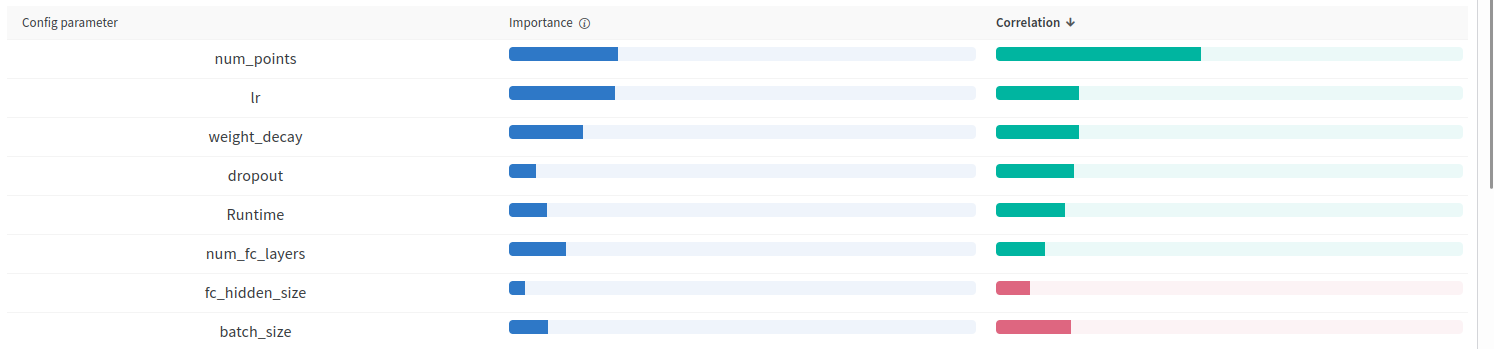
W&B parameter importance graph
Analysis:
- num_points: highest importance, strong green -> increasing tends to reduce val_loss
- lr: second highest importance, green -> larger lr within range reduce loss
- weight_decay: moderate importance: more WD helps a bit but limited
- dropout: low importance, green -> more dropout slightly lowers loss
- num_fc_layers: low, faint green -> more layers might help slightly
- fc_hidden_size: very low, slight red -> larger hidden size may slightly worsen loss
- batch_size: low importance, red -> larger batch size increases loss.

We fix the number of fc layers to 2, the hidden size will stay the same, we have a min dropout of 1e-6 now. Weight decay, slightly trim interval, remove 64 from number of points.

Additionally some data augmentation can help
- random jitter for PCs with less than 128 points, resample
- rotation augmentation

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
class ConeClusterDataset(Dataset):
    def __init__(self, json_files, num_points=128, jitter=True, rotate=True, resample=True, idx=None):
        """
        json_files: list of paths to your JSON cluster files
        num_points: fixed number of points per cluster
        jitter: whether to apply small random noise to point coordinates
        rotate: whether to apply small random rotation around Z axis
        resample: whether to resample clusters with fewer points than num_points
        """
        self.samples = []
        self.num_points = num_points
        self.jitter = jitter
        self.rotate = rotate
        self.resample = resample

        counter = 0
        for file_path in json_files:
            with open(file_path, 'r') as f:
                data = json.load(f)
            for frame in data.values():
                for cluster in frame['clusters']:
                    if idx is not None and counter not in idx:
                        counter += 1
                        continue
                    points = cluster['points']
                    label = cluster['label']
                    if label == 255:
                        label = 0
                    self.samples.append((points, label))
                    counter += 1

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        points, label = self.samples[idx]

        # Convert to numpy array (N, 4) [x, y, z, intensity]
        pts = np.array([[p['x'], p['y'], p['z'], p['i']] for p in points], dtype=np.float32)
        N = pts.shape[0]

        # Normalize coordinates relative to centroid
        centroid = pts[:, :3].mean(axis=0, keepdims=True)
        pts[:, :3] -= centroid

        # Normalize intensity
        pts[:, 3] /= 255.0

        # ----------------------------
        # Augmentations
        # ----------------------------
        # Resample if too few points

        if N >= self.num_points:
            choice = np.random.choice(N, self.num_points, replace=False)
            pts = pts[choice]
        
        else:
            if self.resample:
                extra_choice = np.random.choice(N, self.num_points - N, replace=True)
                extra_pts = pts[extra_choice]
                extra_pts[:, :3] += np.random.normal(0, 0.001, size=extra_pts[:, :3].shape)  # small jitter
                pts = np.vstack([pts, extra_pts])
            else:
                pad = np.zeros((self.num_points - N, pts.shape[1]), dtype=np.float32)
                pts = np.vstack([pts, pad])
        # Random rotation around Z-axis
        if self.rotate:
            theta = np.random.uniform(-np.pi/8, np.pi/8)  # small rotation
            cos_theta, sin_theta = np.cos(theta), np.sin(theta)
            R = np.array([[cos_theta, -sin_theta, 0],
                          [sin_theta,  cos_theta, 0],
                          [0, 0, 1]], dtype=np.float32)
            pts[:, :3] = pts[:, :3] @ R.T

        # Jitter points
        if self.jitter:
            pts[:, :3] += np.random.normal(scale=0.005, size=(pts.shape[0], 3)).astype(np.float32)

        return torch.tensor(pts, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [ ]:
import wandb
wandb.login()
sweep_config2 = {
    "method": "bayes",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "lr": {"min": 1e-4, "max": 1e-2},
        "batch_size": {"values": [8, 16]},
        "num_fc_layers": {"values": [2]},
        "fc_hidden_size": {"values": [128, 256, 512]},
        "weight_decay": {"min": 1e-6, "max": 1e-3},
        "dropout": {"min": 0.15, "max": 0.3},
        "num_points": {"values": [128, 256]},
        "jitter" : {"values": [True, False]},
        "rotate" : {"values": [True, False]},
        "resample" : {"values": [True, False]}
    }
}

sweep_id2 = wandb.sweep(sweep_config2, project="pointnet-conesv2")


In [ ]:
NUM_OF_CLASSES = 4
NUM_OF_EPOCHS = 100
NUM_OF_FROZEN_BACKBONE_EPOCHS = 5

In [ ]:
def train():
    # Initialize W&B run
    run = wandb.init()
    sweep_id = run.sweep_id  # sweep ID (e.g., "sweep15")
    run_id = run.id          # run ID (unique per trial)
    print("Sweep ID:", sweep_id)
    print("Run ID:", run_id)
    config = wandb.config

    model_path = f"pointnet_{sweep_id}_{run_id}.pth"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ----------------------------
    # Dataset
    # ----------------------------
    dataset = ConeClusterDataset(train_files, num_points=config.num_points)
    labels = np.array([dataset[i][1].item() for i in range(len(dataset))])

    train_idx, temp_idx = train_test_split(np.arange(len(labels)), test_size=0.2, stratify=labels, random_state=599)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=labels[temp_idx], random_state=599)

    train_dataset = ConeClusterDataset(train_files, num_points=config.num_points, jitter=config.jitter, rotate=config.rotate, resample=config.resample, idx=train_idx)
    val_dataset = ConeClusterDataset(train_files, num_points=config.num_points, jitter=False, rotate=False, resample=False, idx=val_idx)
    test_dataset = ConeClusterDataset(train_files, num_points=config.num_points, jitter=False, rotate=False, resample=False, idx=test_idx)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    set_seeds(599)

    # ----------------------------
    # Model
    # ----------------------------
    encoder_model = PointNetEncoder(in_channels=4)

    # load backbone
    checkpoint = torch.load("../models/pre-trained/pointnet_pre_trainder.pth", map_location="cpu")
    state_dict = checkpoint['model']
    new_state_dict = {k.replace("encoder.", ""): v for k, v in state_dict.items() if "prediction" not in k}
    encoder_model.load_state_dict(new_state_dict, strict=False)
    encoder_model.to(device)
    encoder_model.eval()

    # Build classifier head dynamically
    layers = []
    input_size = 1024
    for i in range(config.num_fc_layers):
        output_size = config.fc_hidden_size
        if i == config.num_fc_layers - 1:
            output_size = NUM_OF_CLASSES
        layers.append(nn.Linear(input_size, output_size))
        if i != config.num_fc_layers - 1:
            layers.append(nn.ReLU())
            if config.dropout > 0:
                layers.append(nn.Dropout(config.dropout))
            input_size = config.fc_hidden_size
    classifier_head = nn.Sequential(*layers).to(device)

    model = PointNetWithHead(encoder_model, classifier_head).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    criterion = nn.CrossEntropyLoss()

    # ----------------------------
    # Freeze backbone for first N epochs
    # ----------------------------
    TOTAL_EPOCHS = NUM_OF_EPOCHS
    for param in encoder_model.parameters():
        param.requires_grad = False

    # ----------------------------
    # Training loop
    # ----------------------------
    best_val_loss = float("inf")
    patience = 10
    patience_counter = 0
    
    for epoch in range(TOTAL_EPOCHS):
        model.train()

        # Unfreeze backbone if we pass frozen epochs
        if epoch == NUM_OF_FROZEN_BACKBONE_EPOCHS:
            for param in encoder_model.parameters():
                param.requires_grad = True
            print(f"Epoch {epoch+1}: Unfroze backbone, now fine-tuning entire model")

        running_loss = 0.0
        correct = 0
        total = 0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / val_total

        wandb.log({
            "epoch": epoch+1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })

        print(f"Epoch {epoch+1}/{TOTAL_EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                model.load_state_dict(torch.load(model_path))
                break
    # ----------------------------
    # Test evaluation
    # ----------------------------
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_loss /= len(test_loader.dataset)
    test_acc = test_correct / test_total
    wandb.log({"test_loss": test_loss, "test_acc": test_acc})
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


In [ ]:
wandb.agent(sweep_id2, function=train, count=20)


From the feature importance we can see the following:
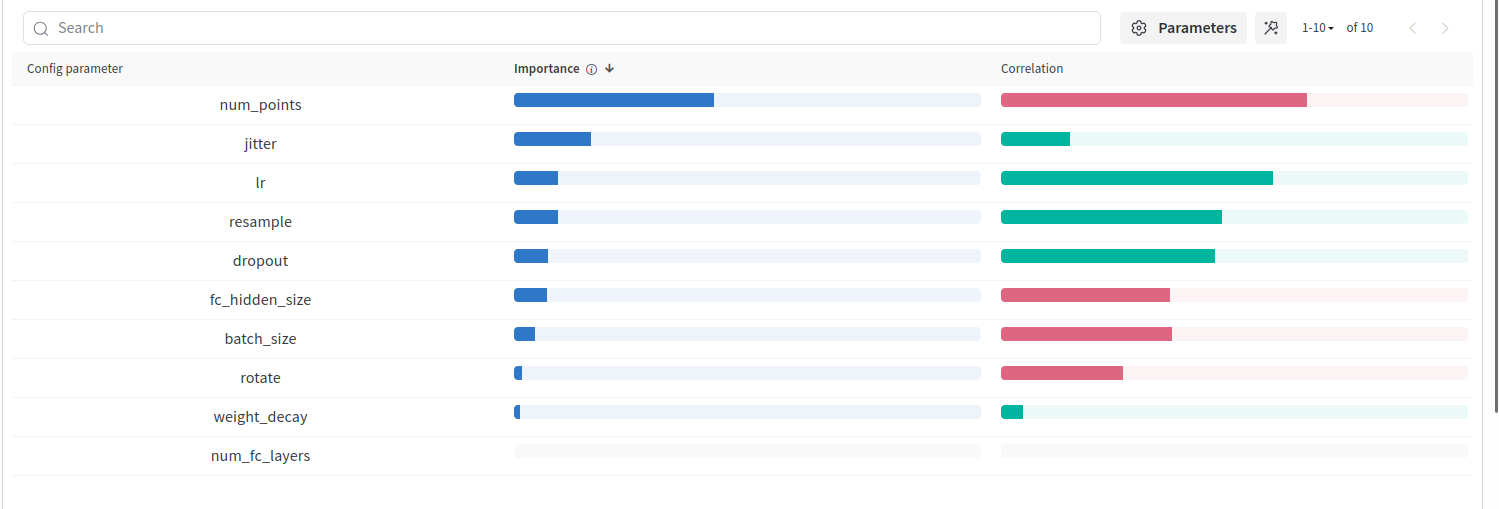

- num_points: we will set it fixed to 128
- jitter: seems to help
- lr: really good right now, keep the same
- dropout: really good right now, will keep
- fc_hidden_size: will delete 512 and put to 256
- batch_size: put to 8
- rotate: False -> very negative effect
- weight decay: keep as is

In [ ]:
wandb.login()
sweep_config3 = {
    "method": "bayes",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "lr": {"min": 1e-4, "max": 1e-2},
        "batch_size": {"values": [8, 16]},
        "num_fc_layers": {"values": [2]},
        "fc_hidden_size": {"values": [256]},
        "weight_decay": {"min": 1e-6, "max": 1e-3},
        "dropout": {"min": 0.15, "max": 0.3},
        "num_points": {"values": [128]},
        "jitter" : {"values": [True, False]},
        "rotate" : {"values": [False]},
        "resample" : {"values": [True, False]}
    }
}

sweep_id3 = wandb.sweep(sweep_config3, project="pointnet-conesv3")

In [ ]:
wandb.agent(sweep_id3, function=train, count=8)
